In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import fft
from scipy import signal as sig
import warnings
import random 
import math
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq
from scipy import signal as sig
from cmath import phase
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import sympy as sym
from sympy import pi
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, roc_auc_score, f1_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
#https://stackoverflow.com/questions/4364823/how-do-i-obtain-the-frequencies-of-each-value-in-an-fft/4371627#4371627

In [2]:
male_shannon_df = pd.read_csv('/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/male_shannon.csv')
female_shannon_df = pd.read_csv('/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/female_shannon.csv', index_col = [0])

### FFT ON WHOLE SERIES

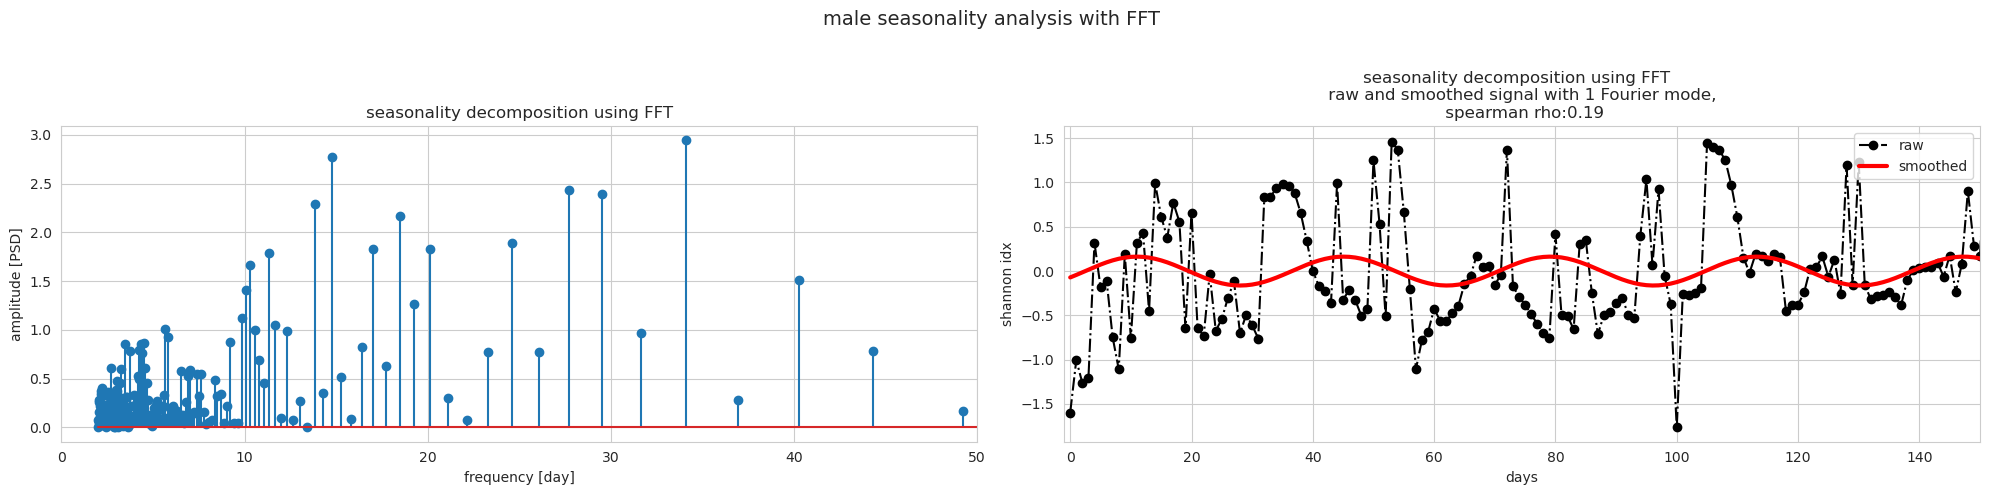

In [3]:
# fft on full time series
subject = 'male'
n_modes = 1

train = male_shannon_df.values
train_detrend = train - train.mean()

x = train_detrend.reshape(len(train_detrend), )

dt = 1 #sampling interval 
n = len(x) #number of samples
fhat = np.fft.fft(x, n) #computes the fft
#ft = np.abs(fhat)

psd = fhat * np.conj(fhat)/n #power density spectrum
freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
period = 1/freq #period


train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                      columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

train_fft_df = train_fft_df.sort_values(by = ['pds_real'], ascending = False)

#plot frequency and dominant modes

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 5))
ax[0].stem(period[idxs_half], psd[idxs_half])
ax[0].set_xlabel('frequency [day]')
ax[0].set_ylabel('amplitude [PSD]')
ax[0].title.set_text('seasonality decomposition using FFT')
ax[0].set_xlim([0, 50])


### filter signal only usig dominant mode 

threshold = train_fft_df['pds_real'].values[0:n_modes]
psd_idxs = np.isin(psd, threshold)
psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean)

score = np.round(stats.spearmanr(signal_filtered, train_detrend)[0], 2)

plt.plot(train_detrend, 'ko-.', label = 'raw')
plt.plot(signal_filtered, 'r-', lw=3, label = 'smoothed')
ax[1].set_xlabel('days')
ax[1].set_ylabel('shannon idx')
ax[1].title.set_text(f'seasonality decomposition using FFT  \n raw and smoothed signal with {n_modes} Fourier mode, \n spearman rho:{score}')
ax[1].legend(loc="upper right")
ax[1].set_xlim([-1, 150])

plt.suptitle(f'{subject} seasonality analysis with FFT \n', size = 14)
plt.tight_layout()
plt.savefig(f'{subject}_full_fft_analysis_zoomed.png', dpi=300)
plt.show()


### CALCULATE RHO VS NUMER OF MODES

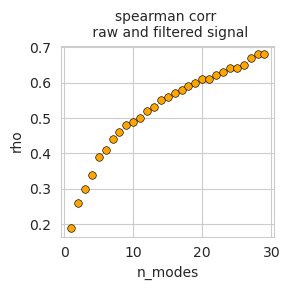

In [20]:
SCORE = []
for n_modes in range(1, 30):
    
    threshold = train_fft_df['pds_real'].values[0:n_modes]
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)
    score = np.round(stats.spearmanr(signal_filtered, train_detrend)[0], 2)
    SCORE.append(score)
    
spearman_rho_df = pd.DataFrame(list(zip(SCORE, [i for i in range(1, 30)])), columns = ['rho', 'n_modes'])

plt.figure(figsize = (3, 3))
sns.scatterplot(x=spearman_rho_df.n_modes, y=spearman_rho_df.rho, color='orange', edgecolor = 'k', s = 30)
plt.title('spearman corr \n raw and filtered signal', size = 10)
plt.tight_layout()
plt.savefig(f'{subject}_spearman_vs_n_modes.png', dpi=300)

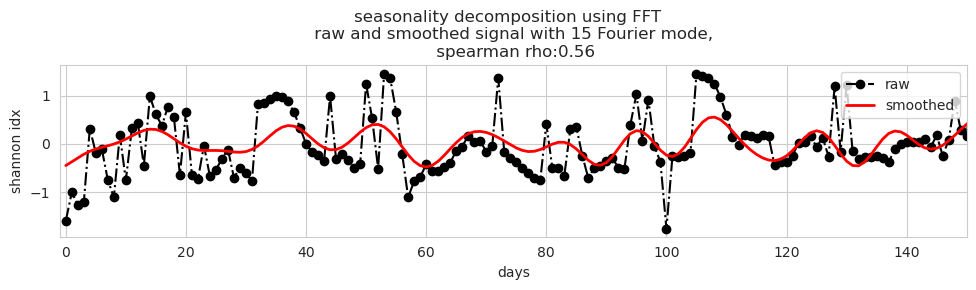

In [27]:
# plot signal filtering with 15 modes
n_modes=15
threshold = train_fft_df['pds_real'].values[0:n_modes]
psd_idxs = np.isin(psd, threshold)
psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean)

score = np.round(stats.spearmanr(signal_filtered, train_detrend)[0], 2)
plt.figure(figsize = (10, 3))

plt.plot(train_detrend, 'ko-.', label = 'raw')
plt.plot(signal_filtered, 'r-', lw=2, label = 'smoothed')
plt.xlabel('days')
plt.ylabel('shannon idx')
plt.title(f'seasonality decomposition using FFT  \n raw and smoothed signal with {n_modes} Fourier mode, \n spearman rho:{score}')
plt.legend(loc="upper right")
plt.xlim([-1, 150])
plt.tight_layout()
plt.savefig(f'{subject}_smoothed.png', dpi=300)

### TRY TO PREDICT TEST SEASONALITY WITH TRAIN PERIOD

In [29]:
def find_and_smooth_singal(train_data, n_modes):
    
    train = train_data.values
    train_detrend = train - train.mean()

    x = train_detrend.reshape(len(train_detrend), )

    dt = 1                   #sampling interval 
    n = len(x)               #number of samples
    fhat = np.fft.fft(x, n)  #computes the fft
    #ft = np.abs(fhat)

    psd = fhat * np.conj(fhat)/n #power density spectrum
    freq = (1/(dt*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
    period = 1/freq #period

    #create a dataframe with psd and period
    train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                          columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

    train_fft_df = train_fft_df.sort_values(by = ['pds_real'], ascending = False)

    threshold = train_fft_df['pds_real'].values[0:n_modes]
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)

    p = np.round(train_fft_df[train_fft_df.pds_real == threshold]['period [days]'].values[0], 2)
    score = np.round(stats.spearmanr(train_detrend, signal_filtered)[0], 2)

    res_df = pd.DataFrame(list(zip(train_detrend.reshape(len(train_detrend), ), signal_filtered)), columns = ['signal', 'signal_smoothed'])
    res_df['period'] = p
    res_df['score'] = score
    
    return res_df, train_fft_df.reset_index(drop=True)

def smooth_test_signal(test_data, freq_period, n_modes):
    
    test = test_data.values
    test_detrend = test - test.mean()

    x = test_detrend.reshape(len(test_detrend), )

    dt = 1 
    n = len(x) 
    fhat = np.fft.fft(x, n) 

    psd = fhat * np.conj(fhat)/n #power density spectrum
    freq = (1/(dt*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
    period = 1/freq #period

    #create a dataframe with psd and period
    test_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                          columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

    psd_test = test_fft_df[test_fft_df['freq [1/day]'] == freq_period]['pds_real'].values[0: n_modes]
    
    threshold = psd_test
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)

    p = np.round(test_fft_df[test_fft_df.pds_real == threshold]['period [days]'].values[0], 2)
    score = np.round(stats.spearmanr(test_detrend, signal_filtered)[0], 2)
    
    res_df = pd.DataFrame(list(zip(test_detrend.reshape(len(test_detrend), ), signal_filtered)), columns = ['signal', 'signal_smoothed'])
    res_df['period'] = p
    res_df['score'] = score
    
    return res_df, test_fft_df.reset_index(drop=True)

In [8]:
def test_fft(train_data, test_data, n_modes):
    

    train = train_data.values
    train_detrend = train - train.mean()

    test = test_data.values
    test_detrend = test - test.mean()

    x = train_detrend.reshape(len(train_detrend), )

    dt = 1                   #sampling interval 
    n = len(x)               #number of samples
    fhat = np.fft.fft(x, n)  #computes the fft
    #ft = np.abs(fhat)

    psd = fhat * np.conj(fhat)/n #power density spectrum
    freq = (1/(dt*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
    period = 1/freq #period

    #create a dataframe with psd and period
    train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                          columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

    train_fft_df = train_fft_df.sort_values(by = ['pds_real'], ascending = False) # df with fft analysis results

    threshold = train_fft_df['pds_real'].values[0:n_modes]
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)
    
    train_score = np.round(stats.spearmanr(train_detrend, signal_filtered)[0], 2)

    train_raw_filtered_data_df = pd.DataFrame(list(zip(train_detrend[:, 0], signal_filtered)), # df with raw and filtered signal
                                              columns = ['signal', 'signal_smoothed'])
    
    train_period = train_fft_df['freq [1/day]'].values[0:n_modes] # get n dominating modes
    train_raw_filtered_data_df['period'] = str(train_fft_df[train_fft_df['freq [1/day]'].isin(train_period)]['period [days]'].values)
    train_raw_filtered_data_df['score'] = train_score
     
    
    # test period on test 
    
    x = test_detrend.reshape(len(test_detrend), )

    dt = 1 
    n = len(x) 
    fhat = np.fft.fft(x, n) 

    psd = fhat * np.conj(fhat)/n #power density spectrum
    freq = (1/(dt*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
    period = 1/freq #period

    #create a dataframe with psd and period
    test_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                          columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

    psd_test = test_fft_df[test_fft_df['freq [1/day]'].isin(train_period)]['pds_real'].values

    threshold = psd_test
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)

    # calculate spearman corr
    test_score = np.round(stats.spearmanr(test_detrend, signal_filtered)[0], 2)

    test_raw_filtered_data_df = pd.DataFrame(list(zip(test_detrend[:, 0], signal_filtered)), # df with raw and filtered signal
                                              columns = ['signal', 'signal_smoothed'])

    test_raw_filtered_data_df['period'] = str(test_fft_df[test_fft_df['freq [1/day]'].isin(train_period)]['period [days]'].values)
    test_raw_filtered_data_df['score'] = test_score

    return train_raw_filtered_data_df, test_raw_filtered_data_df

In [9]:
def fft_sliding_window(data, N, step, n_modes):
    
    N = N
    step = step
    n_modes = n_modes
    lim = 300
    
    RESULTS = []
    for i in range(0, lim, step):
        
        train = data.iloc[i:(N+i)]
        test = data.iloc[(N+i):((N + N) +i)]

        train_smoothed, test_smoothed = test_fft(train, test, n_modes)

        train_smoothed['data'] = 'train'
        test_smoothed['data'] = 'test'

        DF = pd.concat([train_smoothed, test_smoothed]).reset_index(drop=True)
        DF['n_modes'] = n_modes
        DF['fold'] = i

        RESULTS.append(DF)
        
    RESULTS_DF = pd.concat(RESULTS)
    RESULTS_DF['n_modes'] = n_modes
    
    periods_df = RESULTS_DF.drop_duplicates(subset = ['fold'])[['period', 'fold']]

    score_df = RESULTS_DF.drop_duplicates(subset = ['fold', 'data'])
    score_train = score_df[score_df['data'] == 'train']
    score_test = score_df[score_df['data'] == 'test']

    dict_train = dict(zip(score_train.fold, score_train.score))
    dict_test = dict(zip(score_test.fold, score_test.score))

    periods_df['spearman_train'] = periods_df['fold']
    periods_df['spearman_test'] = periods_df['fold']
    periods_df = periods_df.replace({"spearman_train": dict_train}).replace({"spearman_test": dict_test})

    treshold = 0.2
    periods_df['train_wins'] = np.where(periods_df['spearman_train'] >= treshold, 1, 0)
    periods_df['test_wins'] = np.where(periods_df['spearman_test'] >= treshold, 1, 0)
    periods_df['train_looses'] = np.where(periods_df['spearman_train'] < treshold, 1, 0)
    periods_df['test_looses'] = np.where(periods_df['spearman_test'] < treshold, 1, 0)

    
    return RESULTS_DF, periods_df

In [10]:
subject = 'male'
N = 50
step = 5

RESULT_BIG = []
PERIOD_BIG = []
for n_modes in range(1, 20):
    RESULTS_DF, periods_df = fft_sliding_window(male_shannon_df, N, step, n_modes)
    
    RESULTS_DF['n_modes'] = n_modes
    periods_df['n_modes'] = n_modes
    
    RESULT_BIG.append(RESULTS_DF)
    PERIOD_BIG.append(periods_df)
    
RESULT_BIG_DF =  pd.concat(RESULT_BIG)
PERIOD_BIG_DF =  pd.concat(PERIOD_BIG)

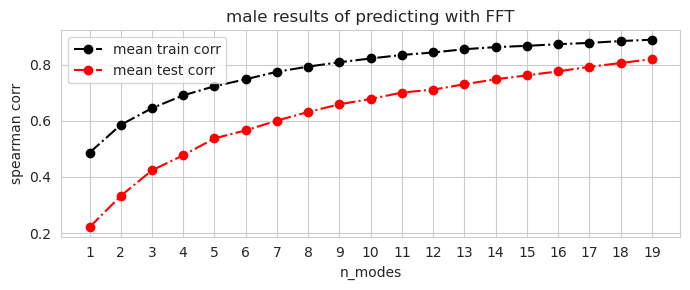

In [18]:
train_mean_rho = RESULT_BIG_DF[RESULT_BIG_DF['data'] == 'train'].groupby(by = ['n_modes']).mean().reset_index()
test_mean_rho = RESULT_BIG_DF[RESULT_BIG_DF['data'] == 'test'].groupby(by = ['n_modes']).mean().reset_index()

plt.figure(figsize = (7, 3))
plt.plot(train_mean_rho.n_modes.astype(str), train_mean_rho.score, 'ko-.', label = 'mean train corr')
plt.plot(train_mean_rho.n_modes.astype(str), test_mean_rho.score, 'ro-.', label = 'mean test corr')
plt.legend()
plt.xlabel('n_modes')
plt.ylabel('spearman corr')
plt.title(f'{subject} results of predicting with FFT')
plt.tight_layout()
plt.savefig(f'{subject}_modes_speamrman_sliding.png', dpi=300)

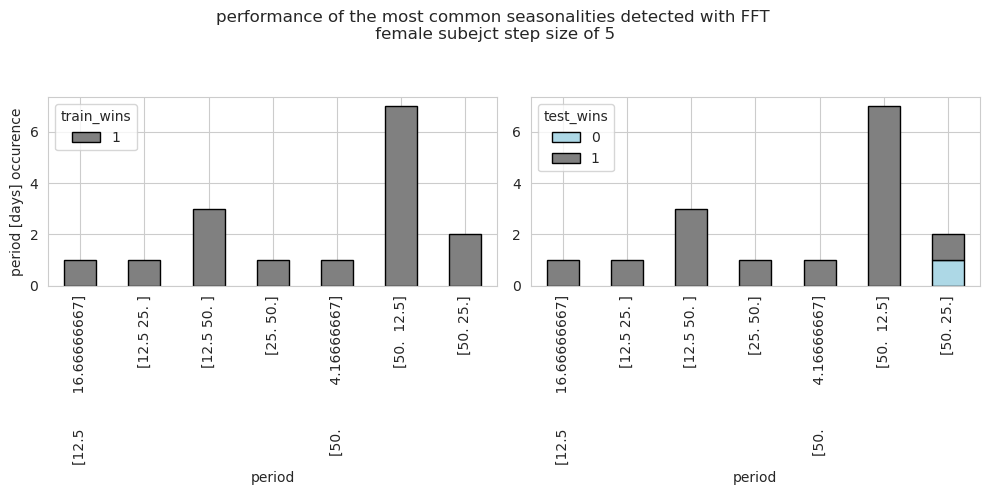

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

periods_df.sort_values(by = ['period']).groupby(['period', 'train_wins']).size().unstack().plot(kind='bar', 
                                                                                                stacked=True, 
                                                                                                color = ['grey'], 
                                                                                                edgecolor = 'k',
                                                                                               ax = ax[0])

periods_df.sort_values(by = ['period']).groupby(['period', 'test_wins']).size().unstack().plot(kind='bar',
                                                                                               stacked=True, 
                                                                                               color = ['lightblue', 'grey'], 
                                                                                               edgecolor = 'k',
                                                                                               ax = ax[1])
plt.suptitle(f'performance of the most common seasonalities detected with FFT \n {subject} subejct step size of {step} \n \n')
ax[0].set_ylabel('period [days] occurence')
plt.tight_layout()
plt.savefig(f'{subject}_fft_score_step{step}_{n_modes}modes.png', dpi=300)

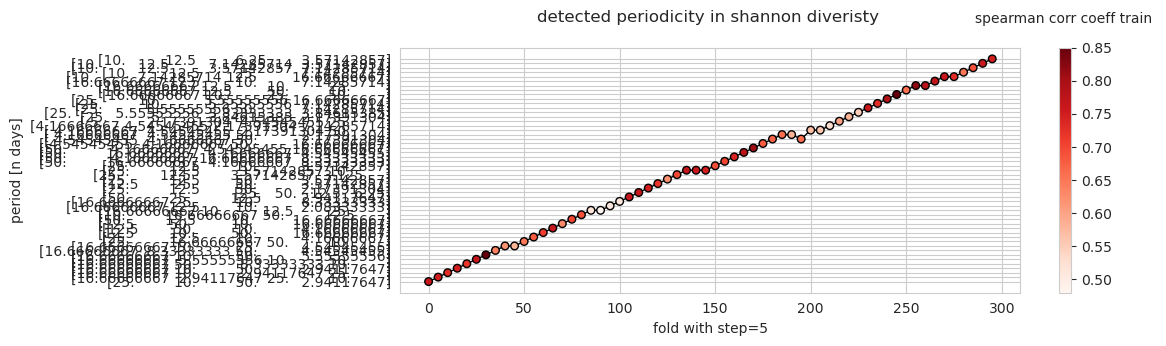

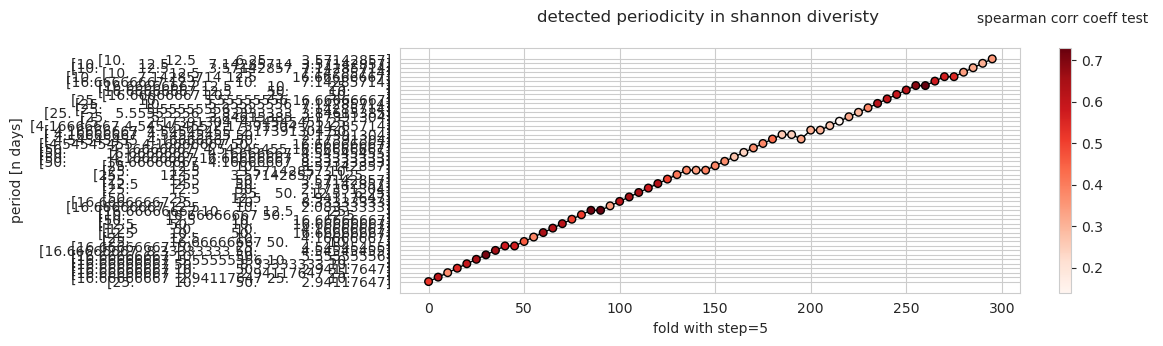

In [13]:
cmap = sns.color_palette(palette = 'Reds', as_cmap=True)

plt.figure(figsize =(10, 7))
plt.subplot(212)

plt.plot(periods_df.fold, periods_df.period, 'k', zorder=1, lw=1)
points = plt.scatter(periods_df.fold, 
                    periods_df.period, 
                    c = periods_df.spearman_train, 
                    s=30,
                    cmap=cmap,
                   edgecolor = 'k', 
                    zorder=2
               )
clb = plt.colorbar(points)
clb.ax.set_title('spearman corr coeff train \n',fontsize=10)
plt.ylabel('period [n days]')
plt.xlabel(f'fold with step={step}')
plt.title('detected periodicity in shannon diveristy \n')
#plt.savefig(f'fft_{subject}_train_step{step}.png', dpi =100)
plt.show()

plt.figure(figsize =(10, 7))
plt.subplot(212)

plt.plot(periods_df.fold, periods_df.period, 'k', zorder=1, lw=1)
points = plt.scatter(periods_df.fold, 
                    periods_df.period, 
                    c = periods_df.spearman_test, 
                    s=30,
                    cmap=cmap,
                   edgecolor = 'k', 
                    zorder=2
               )
clb = plt.colorbar(points)
clb.ax.set_title('spearman corr coeff test \n',fontsize=10)
plt.ylabel('period [n days]')
plt.xlabel(f'fold with step={step}')
plt.title('detected periodicity in shannon diveristy \n')
#plt.savefig(f'fft_{subject}_test_step{step}_{n_modes}modes.png', dpi =100)
plt.show()


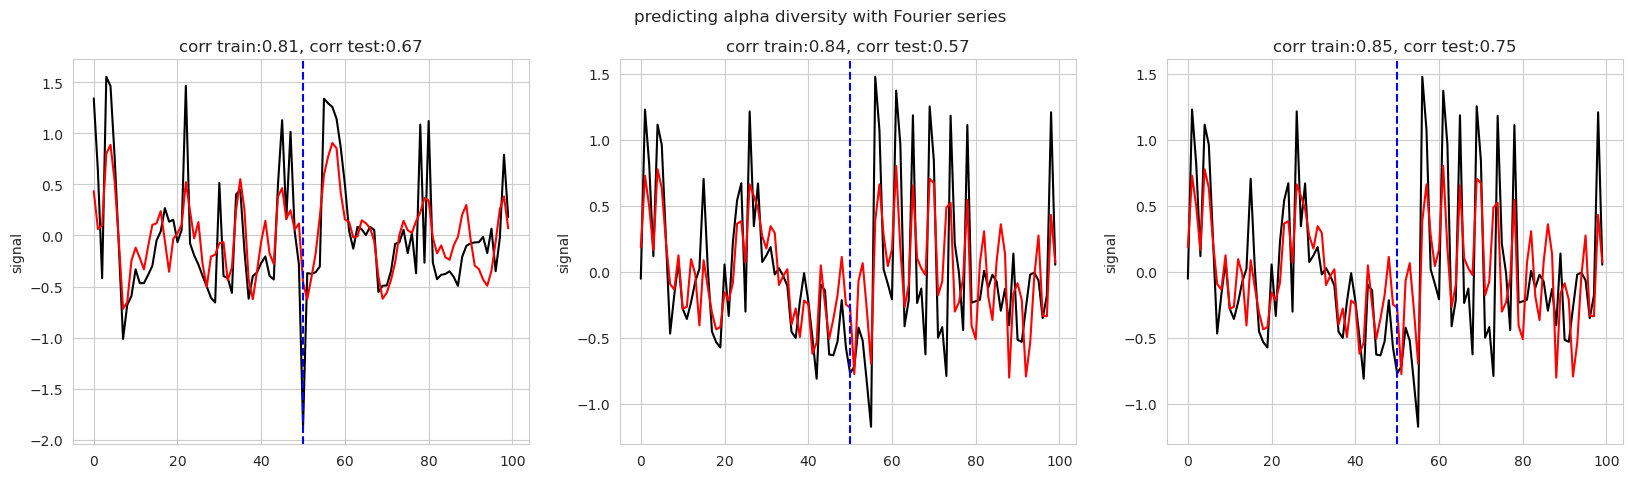

In [17]:
n_modes = 10
periods_df = PERIOD_BIG_DF[PERIOD_BIG_DF['n_modes'] == n_modes]
results_df = RESULT_BIG_DF[RESULT_BIG_DF['n_modes'] == n_modes]

plot1 = results_df[results_df['fold'] == 50]
plot2 = results_df[results_df['fold'] == 150]
plot3 = results_df[results_df['fold'] == 250]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 5))

sns.lineplot(x = range(len(plot1)), y = plot1.signal, color='k', ax =ax[0])
sns.lineplot(x = range(len(plot1)), y = plot1.signal_smoothed, color='r', ax =ax[0])
sns.lineplot(x = range(len(plot2)), y = plot2.signal, color='k', ax =ax[1])
sns.lineplot(x = range(len(plot2)), y = plot2.signal_smoothed, color='r', ax =ax[1])
sns.lineplot(x = range(len(plot3)), y = plot2.signal, color='k', ax =ax[2])
sns.lineplot(x = range(len(plot3)), y = plot2.signal_smoothed, color='r', ax =ax[2])

plt.suptitle('predicting alpha diversity with Fourier series \n \n')

rho_train1 = plot1[plot1['data'] == 'train'].score.values[0]
rho_test1 = plot1[plot1['data'] == 'test'].score.values[0]

rho_train2 = plot2[plot2['data'] == 'train'].score.values[0]
rho_test2 = plot2[plot2['data'] == 'test'].score.values[0]

rho_train3 = plot3[plot3['data'] == 'train'].score.values[0]
rho_test3 = plot3[plot3['data'] == 'test'].score.values[0]

period1 = plot1[plot1['data'] == 'train'].period.values[0]
period2 = plot2[plot2['data'] == 'train'].period.values[0]
period3 = plot3[plot3['data'] == 'train'].period.values[0]

ax[0].axvline(50,color='blue',ls='--')
ax[1].axvline(50,color='blue',ls='--')
ax[2].axvline(50,color='blue',ls='--')

ax[0].title.set_text(f'corr train:{rho_train1}, corr test:{rho_test1}')
ax[1].title.set_text(f'corr train:{rho_train2}, corr test:{rho_test2}')
ax[2].title.set_text(f'corr train:{rho_train3}, corr test:{rho_test3}')

plt.savefig(f'{subject}_prediction_step{step}_{n_modes}modes.png')

### approximate alpha diversity with fft of given amplitude


In [13]:
subject = 'female'

In [14]:
def lin_reg_fft(train_fold_size, test_fold_size):

    TRAIN_SCORE = []; TEST_SCORE = []
    for n in range (0, 60, 10):

        train = female_shannon_df[n:n+train_fold_size].values
        test = female_shannon_df[n+train_fold_size:(n+train_fold_size+test_fold_size)].values

        #detrent train for fft
        train_detrend = train - train.mean() 
        x = train_detrend.reshape(len(train_detrend), )

        #analye train with fft to select dominant frequencies

        dt = 1 #sampling interval 
        n = len(x) #number of samples
        fhat = np.fft.fft(x, n) #computes the fft
        #ft = np.abs(fhat)

        psd = fhat * np.conj(fhat)/n #power density spectrum
        freq = (1/(dt*n)) * np.arange(n) #frequency array
        idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
        period = 1/freq #period


        train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                              columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

        amplitudes_df = train_fft_df.sort_values(by = ['pds_real'], ascending = False)
        amp1 = amplitudes_df['period [days]'].iloc[0] #get the dominant frequency

        #make fourier series with given amplitude (len == train + test)

        N = train_fold_size+test_fold_size    
        T = 1/1 
        f = 1/amp1
        x = np.linspace(0, N*T, N, endpoint=False)
        ft = np.cos(f * 2.0*np.pi*x) + np.sin(f * 2.0*np.pi*x)

        #use ft series for train and test
        ft_train = ft[:n]
        ft_test = ft[n:]

        #make linear regression model where we predict apha diversity with fourier series
        y_train = pd.DataFrame(train, columns=['shannon']) #shannon
        train_time = np.arange(0, train_fold_size)
        X_train = pd.DataFrame(list(zip(ft_train, train_time)), columns=['fft', 'time']) 
        #X_train = pd.DataFrame(ft_train, columns=['fft']) 
        test_time = np.arange(0, test_fold_size)
        X_test = pd.DataFrame(list(zip(ft_test, test_time)), columns=['fft', 'time'])
        #X_test = pd.DataFrame(ft_test, columns=['fft']) 

        model = LinearRegression()
        model.fit(X_train, y_train)

        #predict train and test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #analyse score
        train_score = np.round(stats.spearmanr(train, y_train_pred)[0], 2)
        test_score = np.round(stats.spearmanr(test, y_test_pred)[0], 2)
        '''
        #plot results
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,3))

        ax[0].plot(y_train.values, 'ko-.')
        ax[0].plot(y_train_pred, 'r-')
        ax[0].set_title(f'train score: {train_score}')
        ax[1].plot(test, 'ko-.')
        ax[1].plot(y_test_pred, 'g-')
        ax[1].set_title(f'test score: {test_score}')

        plt.show()
        '''
        TRAIN_SCORE.append(train_score)
        TEST_SCORE.append(test_score)

    rho_df = pd.DataFrame(list(zip(TRAIN_SCORE, TEST_SCORE)), columns = ['train_rho', 'test_rho'])
    rho_df['train_size'] = train_fold_size
    rho_df['test_size'] = test_fold_size
    
    return rho_df

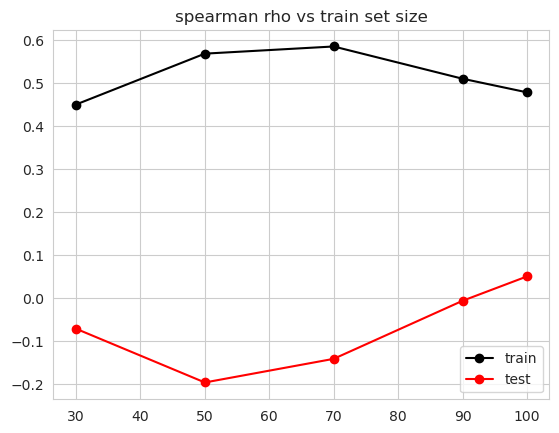

In [18]:
#train_sizes = [30, 50, 70, 100, 150, 200, 250]
train_sizes = [30, 50, 70,  90, 100]

RHO_L = []
for train in train_sizes:
    df = lin_reg_fft(train, 30)
    RHO_L.append(df)
RHO_DF = pd.concat(RHO_L)

rho= RHO_DF.groupby(by = ['train_size']).mean().reset_index()
plt.plot(rho.train_size, 
          rho.train_rho, 'ko-', label='train')
plt.plot(rho.train_size, 
          rho.test_rho, 'ro-', label='test')
plt.title('spearman rho vs train set size')
plt.legend()
plt.savefig(f'/storage/zkarwowska/microbiome-dynamics-preprint/plots/fft_analysis_of_shannon_diversity/{subject}_train_size_rho.png', dpi =200)

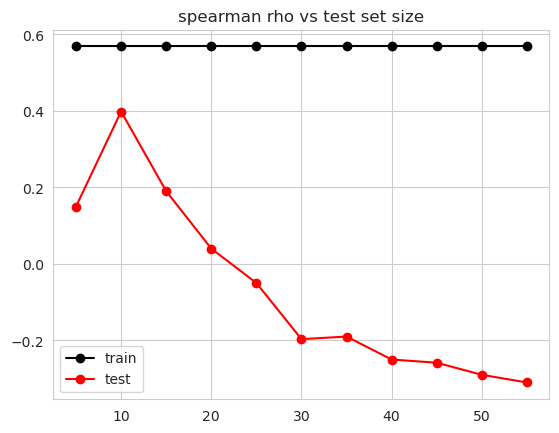

In [66]:
test_sizes = [i for i in range(5, 60, 5)]

RHO_L = []
for test in test_sizes:
    df = lin_reg_fft(50, test)
    RHO_L.append(df)
RHO_DF = pd.concat(RHO_L)
   
    
rho= RHO_DF.groupby(by = ['test_size']).mean().reset_index()

plt.plot(rho.test_size, 
          rho.train_rho, 'ko-', label='train')
plt.plot(rho.test_size, 
          rho.test_rho, 'ro-', label='test')

plt.title('spearman rho vs test set size')
plt.legend()
plt.savefig(f'/storage/zkarwowska/microbiome-dynamics-preprint/plots/fft_analysis_of_shannon_diversity/{subject}_test_size_rho.png', dpi =200)

In [21]:
def fft_n_modes(n_modes):
    
    train_fold_size = 50
    test_fold_size = 10

    TRAIN_SCORE = []; TEST_SCORE = []
    for n in range (0, 60, 10):

        train = female_shannon_df[n:n+train_fold_size].values
        test = female_shannon_df[n+train_fold_size:(n+train_fold_size+test_fold_size)].values

        #detrent train for fft
        train_detrend = train - train.mean() 
        x = train_detrend.reshape(len(train_detrend), )

        #analye train with fft to select dominant frequencies

        dt = 1 #sampling interval 
        n = len(x) #number of samples
        fhat = np.fft.fft(x, n) #computes the fft
        #ft = np.abs(fhat)

        psd = fhat * np.conj(fhat)/n #power density spectrum
        freq = (1/(dt*n)) * np.arange(n) #frequency array
        idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
        period = 1/freq #period


        train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], 
                                             np.real(psd[idxs_half]), 
                                             period[idxs_half], 
                                             freq[idxs_half])), 
                                    columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

        def create_fft_series(train, n_modes, amplitudes_df):

            x = train.reshape(len(train), )
            amp_df = amplitudes_df['period [days]'].iloc[0:n_modes]

            fft_df = pd.DataFrame()
            amp_df = amplitudes_df['period [days]'].iloc[0:n_modes].values
            for i in range(0, n_modes):
                amp = amp_df[i]

                N = train_fold_size+test_fold_size    
                T = 1/1 
                f = 1/amp

                x = np.linspace(0, N*T, N, endpoint=False)
                ft = np.cos(f * 2.0*np.pi*x) + np.sin(f * 2.0*np.pi*x)
                fft_df[f'fft_{i}'] = ft
            return fft_df

        fft_input = create_fft_series(train_detrend, n_modes, train_fft_df)

        #use ft series for train and test
        ft_train = fft_input.iloc[:n]
        ft_test = fft_input.iloc[n:]

        #make linear regression model where we predict apha diversity with fourier series
        y_train = pd.DataFrame(train, columns=['shannon']) #shannon
        train_time = np.arange(0, train_fold_size)
        X_train = ft_train
        #X_train['time'] = train_time
        #X_train = pd.DataFrame(ft_train, columns=['fft']) 
        test_time = np.arange(0, test_fold_size)
        X_test = ft_test
        #X_test['time'] = test_time
        #X_test = pd.DataFrame(ft_test, columns=['fft']) 

        model = LinearRegression()
        model.fit(X_train, y_train)

        #predict train and test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #analyse score
        train_score = np.round(stats.spearmanr(train, y_train_pred)[0], 2)
        test_score = np.round(stats.spearmanr(test, y_test_pred)[0], 2)

        TRAIN_SCORE.append(train_score)
        TEST_SCORE.append(test_score)

        rho_df = pd.DataFrame(list(zip(TRAIN_SCORE, TEST_SCORE)), columns = ['train_rho', 'test_rho'])
        rho_df['n_modes'] = n_modes
        
        return rho_df

        '''

        #plot results
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,3))

        ax[0].plot(y_train.values, 'ko-.')
        ax[0].plot(y_train_pred, 'r-')
        ax[0].set_title(f'train score: {train_score}')
        ax[1].plot(test, 'ko-.')
        ax[1].plot(y_test_pred, 'g-')
        ax[1].set_title(f'test score: {test_score}')

        plt.show()
        '''

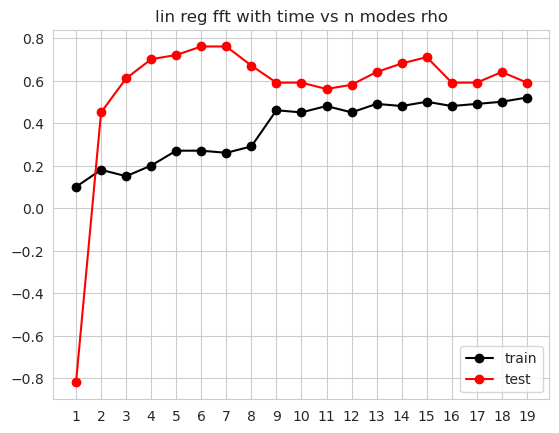

In [69]:
N_MODES_L = []
for n in range(1, 20):
    df = fft_n_modes(n)
    N_MODES_L.append(df)
    
N_MODES_DF = pd.concat(N_MODES_L)

#N_MODES_DF = N_MODES_DF.groupby(by= ['n_modes'])
plt.plot(N_MODES_DF.n_modes.astype(str), 
          N_MODES_DF.train_rho, 'ko-', label='train')
plt.plot(N_MODES_DF.n_modes.astype(str), 
          N_MODES_DF.test_rho, 'ro-', label='test')


plt.title('lin reg fft with time vs n modes rho')
plt.legend()
plt.savefig(f'/storage/zkarwowska/microbiome-dynamics-preprint/plots/fft_analysis_of_shannon_diversity/{subject}_n_modes_rho.png', dpi =200)

### only approx without lnin reg

In [28]:
def fft_approx(n_modes):
    
        TRAIN_SCORE = []; TEST_SCORE = []
        for n in range(0, 60, 5):

            N = 50
            train_fold_size = N
            test_fold_size = N

            train = female_shannon_df[n:n+train_fold_size].values
            test = female_shannon_df[n+train_fold_size:(n+train_fold_size+test_fold_size)].values

            #detrent train for fft
            train_detrend = train - train.mean() 
            test_detrend = test - test.mean() 

            x = train_detrend.reshape(len(train_detrend), )

            #analye train with fft to select dominant frequencies

            dt = 1 #sampling interval 
            n = len(x) #number of samples
            fhat = np.fft.fft(x, n) #computes the fft
            #ft = np.abs(fhat)

            psd = fhat * np.conj(fhat)/n #power density spectrum
            freq = (1/(dt*n)) * np.arange(n) #frequency array
            idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
            period = 1/freq #period


            train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], 
                                                 np.real(psd[idxs_half]), 
                                                 period[idxs_half], 
                                                 freq[idxs_half])), 
                                        columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])

            train_fft_df = train_fft_df.sort_values(by = ['pds'], ascending=False)

            def create_fft_series(train, n_modes, amplitudes_df):

                x = train.reshape(len(train), )
                amp_df = amplitudes_df['period [days]'].iloc[0:n_modes]

                fft_df = pd.DataFrame()
                amp_df = amplitudes_df['period [days]'].iloc[0:n_modes].values
                for i in range(0, n_modes):
                    amp = amp_df[i]

                    N = train_fold_size+test_fold_size    
                    T = 1/1 
                    f = 1/amp

                    x = np.linspace(0, N*T, N, endpoint=False)
                    ft = np.cos(f * 2.0*np.pi*x) + np.sin(f * 2.0*np.pi*x)
                    fft_df[f'fft_{i}'] = ft
                    
                return fft_df

            fft_input = create_fft_series(train_detrend, n_modes, train_fft_df)

            #use ft series for train and test
            ft_train = fft_input.iloc[:N].sum(axis=1)
            ft_test = fft_input.iloc[N:].sum(axis=1)

            train_score = np.round(stats.spearmanr(train_detrend, ft_train)[0], 2)
            test_score = np.round(stats.spearmanr(test_detrend, ft_test)[0], 2)
            TRAIN_SCORE.append(train_score)
            TEST_SCORE.append(test_score)

        rho_df = pd.DataFrame(list(zip(TRAIN_SCORE, TEST_SCORE)), columns = ['train_rho', 'test_rho'])
        rho_df['n_modes'] = n_modes
        
        return rho_df

Text(0.5, 1.0, 'lin reg fft with time vs n modes')

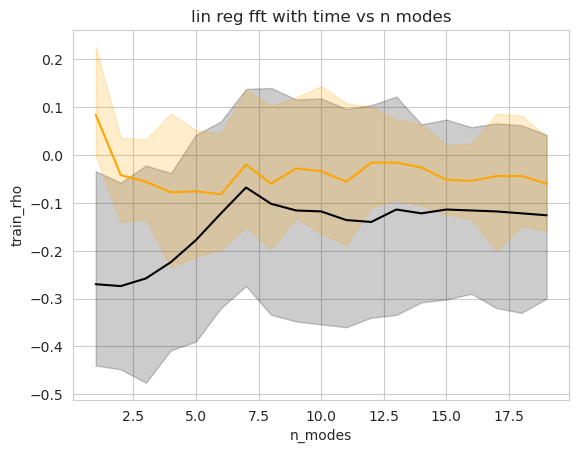

In [31]:
N_MODES_L = []
for n in range(1, 20):
    df = fft_approx(n)
    N_MODES_L.append(df)
    
N_MODES_DF = pd.concat(N_MODES_L)

sns.lineplot(data=N_MODES_DF, 
             x = 'n_modes', 
             y = 'train_rho', 
             err_style='band', color='black')

sns.lineplot(data=N_MODES_DF, 
             x = 'n_modes', 
             y = 'test_rho',
             err_style='band', 
             color='orange')
plt.title('lin reg fft with time vs n modes')